# Project Overview

This project performs an end-to-end Exploratory Data Analysis (EDA) on the Netflix dataset to uncover content trends, global production hubs, and shifts in viewer preferences over the decades.

The dataset is currently stored in the netflix_data.csv database, and its structure is as follows:

### Dataset structure
| Column | Description |
|--------|-------------|
| `show_id` | The ID of the show |
| `type` | Type of show |
| `title` | Title of the show |
| `director` | Director of the show |
| `cast` | Cast of the show |
| `country` | Country of origin |
| `date_added` | Date added to Netflix |
| `release_year` | Year of Netflix release |
| `duration` | Duration of the show in minutes |
| `description` | Description of the show |
| `genre` | Show genre |

# Load and Clean Data

In [72]:
# Import libraries used in the project
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
pio.renderers.default = "notebook_connected"

# 1. Load and Clean Data
df = pd.read_csv('netflix_data.csv')

# Convert date_added to datetime and extract the year
df['date_added'] = pd.to_datetime(df['date_added'].str.strip())
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month_name()

In [73]:
# First look at the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       4812 non-null   object        
 1   type          4812 non-null   object        
 2   title         4812 non-null   object        
 3   director      4812 non-null   object        
 4   cast          4812 non-null   object        
 5   country       4812 non-null   object        
 6   date_added    4812 non-null   datetime64[ns]
 7   release_year  4812 non-null   int64         
 8   duration      4812 non-null   int64         
 9   description   4812 non-null   object        
 10  genre         4812 non-null   object        
 11  year_added    4812 non-null   int32         
 12  month_added   4812 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(9)
memory usage: 470.1+ KB
None


# Filtering the data

In [74]:
# Filter for Movies only for specific analyses
movies_df = df[df['type'] == 'Movie'].copy()

# Set the styling for Seaborn
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Netflix Content Addition Strategy:

**Key Insight**: Since 2015, Netflix has significantly ramped up its library. While Movies still hold the highest total count, the growth rate of TV Shows has outpaced movies in recent years.

**Analysis**: This suggests a strategic shift toward episodic content, which typically yields higher user retention and "binge-watching" behavior compared to one-off films.

Generating Growth Trend...


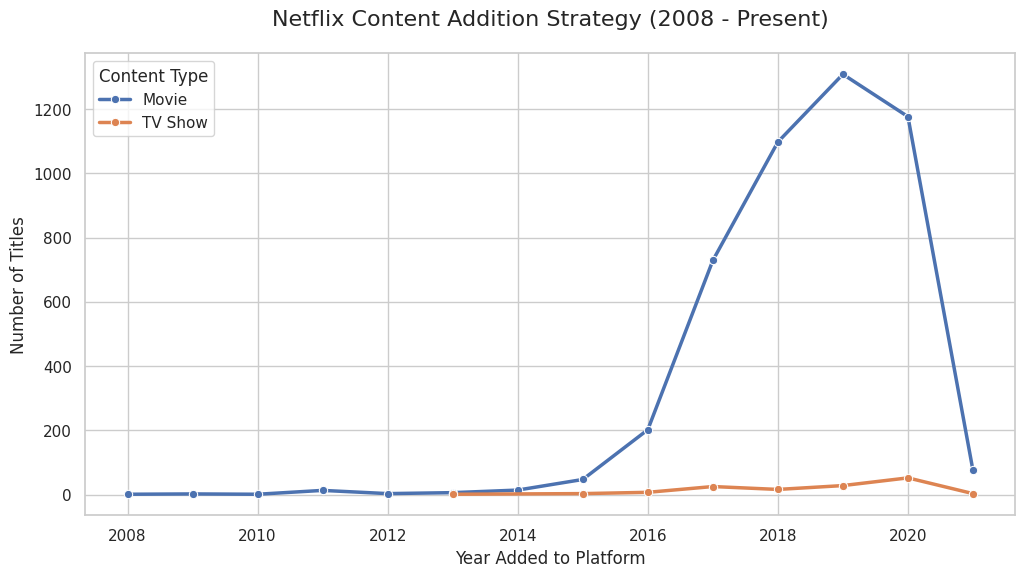

In [75]:
# --- Content Growth Over Time ---
print("Generating Growth Trend...")
content_by_year = df.groupby(['year_added', 'type']).size().reset_index(name='count')
# Focus on the last 12 years for clarity
content_by_year = content_by_year[content_by_year['year_added'] >= 2008]

plt.figure()
sns.lineplot(data=content_by_year, x='year_added', y='count', hue='type', marker='o', linewidth=2.5)
plt.title('Netflix Content Addition Strategy (2008 - Present)', fontsize=16, pad=20)
plt.xlabel('Year Added to Platform', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.legend(title='Content Type')
plt.savefig('netflix_growth_trend.png')

# Global Footprint:

**Key Insight**: The United States remains the dominant content producer, followed closely by India.

**Analysis**: The high volume of Indian content indicates Netflix's heavy investment in the South Asian market. European hubs like the UK and Spain also show strong presence, highlighting the platform's "Global Originals" strategy to capture local markets and export them worldwide (e.g., Money Heist).

Generating Global Analysis...


/tmp/ipython-input-3195143839.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




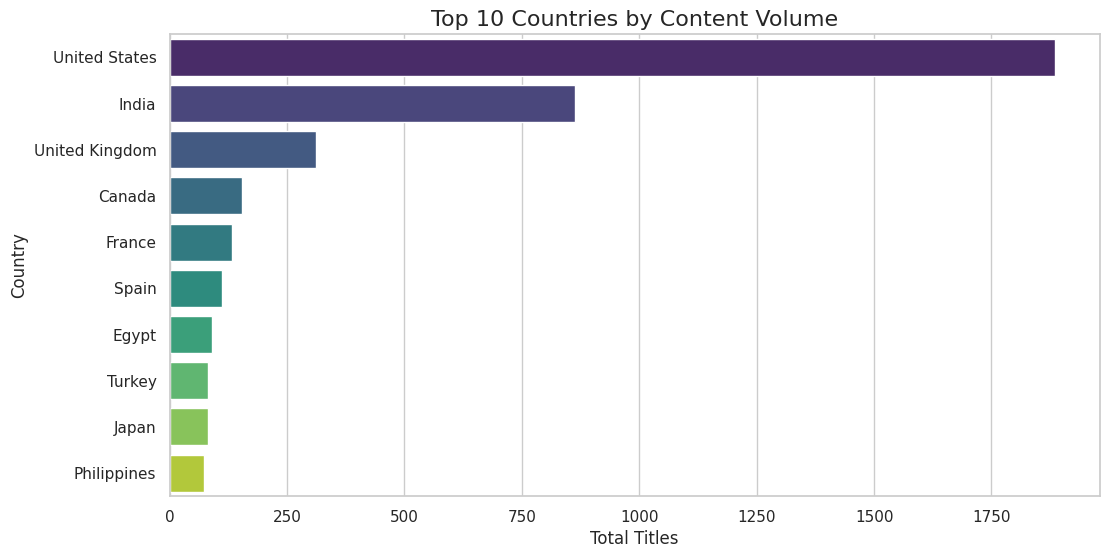

In [76]:
# --- Top 10 Content Producing Countries ---
print("Generating Global Analysis...")
# Handle multiple countries by taking the first one listed
top_countries = df['country'].str.split(',').str[0].value_counts().head(10)

plt.figure()
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top 10 Countries by Content Volume', fontsize=16)
plt.xlabel('Total Titles', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.savefig('top_countries.png')

# Movie Duration:

**Key Insight**: By analyzing the distribution of movie lengths by decade, we see that the median duration for movies has slightly decreased since the 1990s.

**Analysis**: Modern movies (2010s-2020s) show a tighter distribution around the 90–100 minute mark, likely catering to the shrinking attention spans of digital-first audiences, whereas older decades had a wider variance in bigger lengths.

Generating Duration Analysis...


/tmp/ipython-input-211093879.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




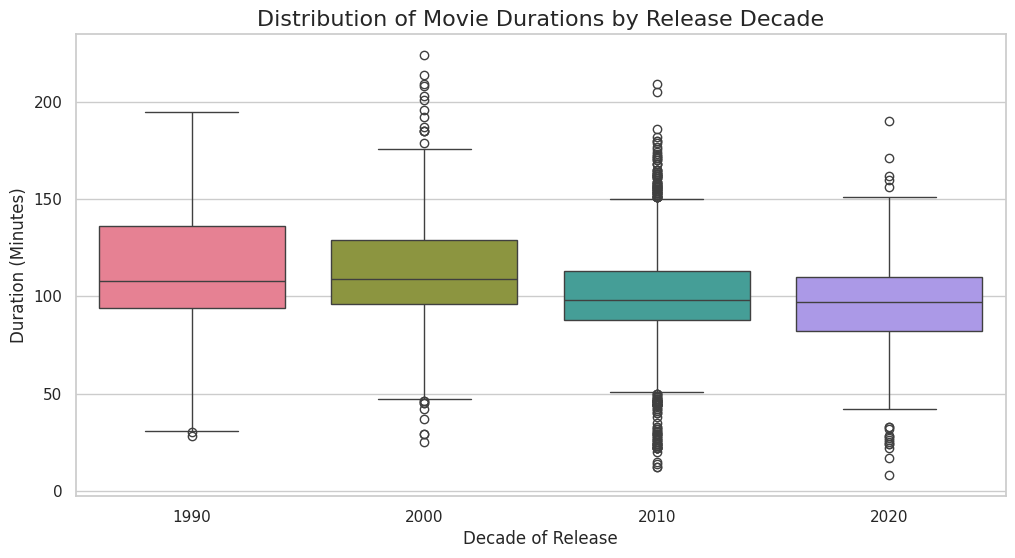

In [77]:
# --- Movie Duration Trends over Decades ---
print("Generating Duration Analysis...")
# Categorize by decade
movies_df['decade'] = (movies_df['release_year'] // 10) * 10

plt.figure()
sns.boxplot(data=movies_df[movies_df['decade'] >= 1990], x='decade', y='duration', palette='husl')
plt.title('Distribution of Movie Durations by Release Decade', fontsize=16)
plt.xlabel('Decade of Release', fontsize=12)
plt.ylabel('Duration (Minutes)', fontsize=12)
plt.savefig('duration_decades.png')

# Content Hierarchy: A Deep Dive into Genres

**Key Insight**: The platform’s library is anchored by Dramas and Comedies in the Movie sector, while TV Shows are heavily dominated by International TV and Crime/Docuseries.

**Analysis**: This distribution reflects a "Global-Local" strategy. By focusing on "International TV," Netflix creates low-cost, high-engagement local content that can be exported globally (like Squid Game or Money Heist), while maintaining a massive volume of "comfort" genres like Comedies to ensure high daily active usage.

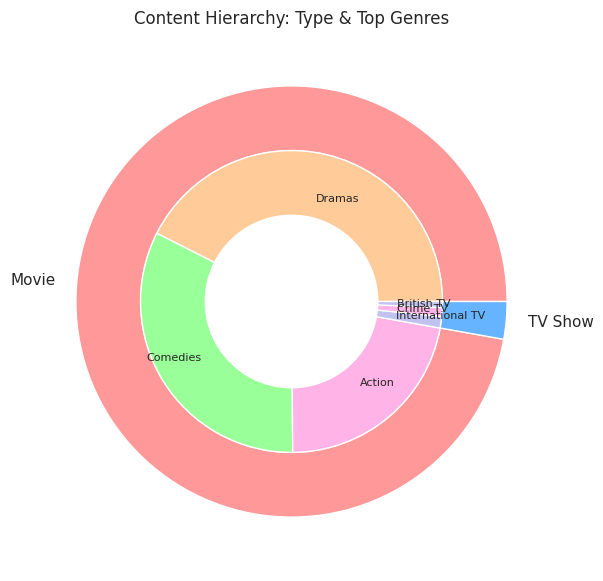

<Figure size 1200x600 with 0 Axes>

In [82]:
# --- INTERACTIVE SUNBURST: Content Hierarchy ---
# Shows the relationship between Type -> Genre
# Prepare data
type_counts = df['type'].value_counts()
genre_counts = df.groupby(['type', 'genre']).size().sort_values(ascending=False).groupby(level=0).head(3)

fig, ax = plt.subplots(figsize=(10, 7))

# Outer Ring (Type)
size = 0.3
ax.pie(type_counts.values, radius=1, labels=type_counts.index,
       wedgeprops=dict(width=size, edgecolor='w'), colors=['#ff9999','#66b3ff'])

# Inner Ring (Top Genres)
ax.pie(genre_counts.values, radius=1-size, labels=genre_counts.index.get_level_values(1),
       labeldistance=0.7, wedgeprops=dict(width=size, edgecolor='w'),
       colors=['#ffcc99','#99ff99','#ffb3e6', '#c2c2f0','#ffb3e6', '#c2c2f0'],
       textprops={'fontsize': 8})

plt.title("Content Hierarchy: Type & Top Genres")
plt.show()
plt.savefig('content_hierarchy.png')

# Seasonality:

(Interactive Heatmap)

**Key Insight**: The heatmap reveals a consistent trend: Netflix adds a massive volume of content in January and December.

**Analysis**: This aligns with peak holiday viewership. By dropping high-profile "Originals" during the winter break, Netflix maximizes its "hours watched" metric when global audiences have the most free time.

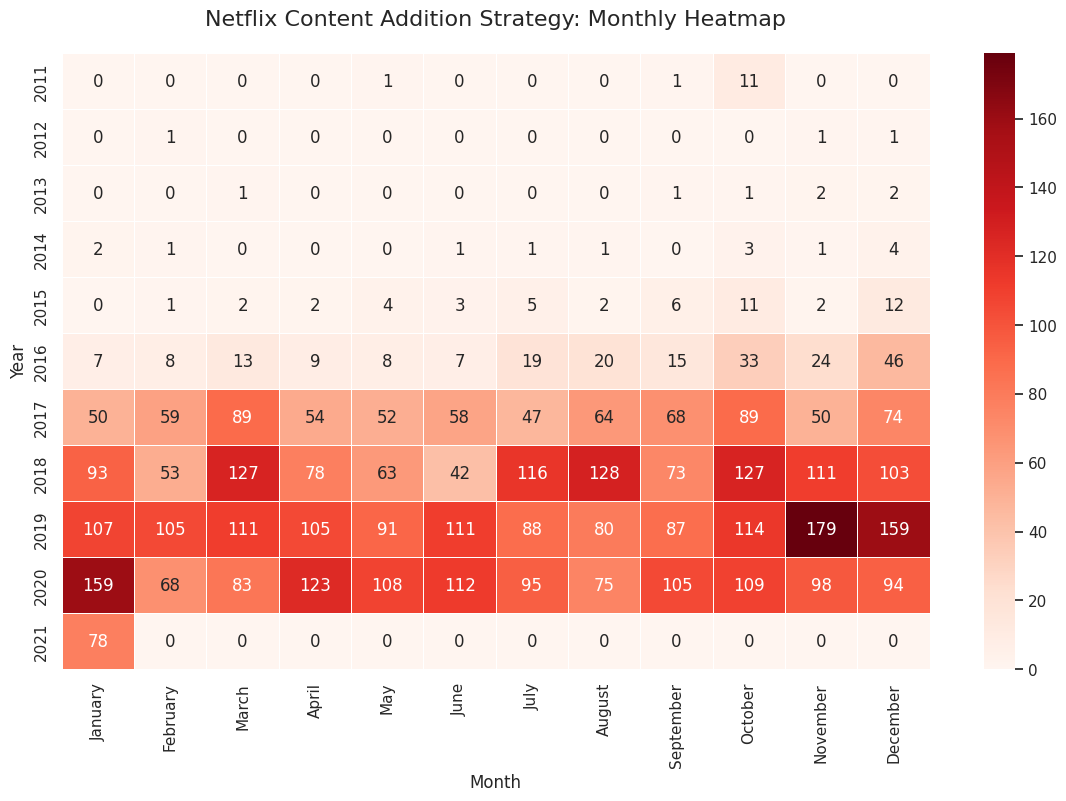

In [85]:
# --- SEASONALITY HEATMAP ---
# Define month order for the heatmap
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

# Prepare the matrix (Filtering for the last 10 years for a cleaner look)
heatmap_df = df[df['year_added'] >= 2011].groupby(['year_added', 'month_added']).size().unstack(fill_value=0)
heatmap_df = heatmap_df.reindex(columns=months_order)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_df, annot=True, fmt="d", cmap="Reds", linewidths=.5)
plt.title("Netflix Content Addition Strategy: Monthly Heatmap", fontsize=16, pad=20)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Year", fontsize=12)
plt.savefig('netflix_seasonality_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Cast Analysis:

(Interactive Bar Chart)

**Key Insight**: The list of most frequent actors is dominated by Indian cinema legends such as Anupam Kher and Shah Rukh Khan.

**Analysis**: This data reveals a "hidden" side of the platform—Netflix is not just a Hollywood library; it is arguably one of the largest distributors of Bollywood content in the world, serving a massive global diaspora.

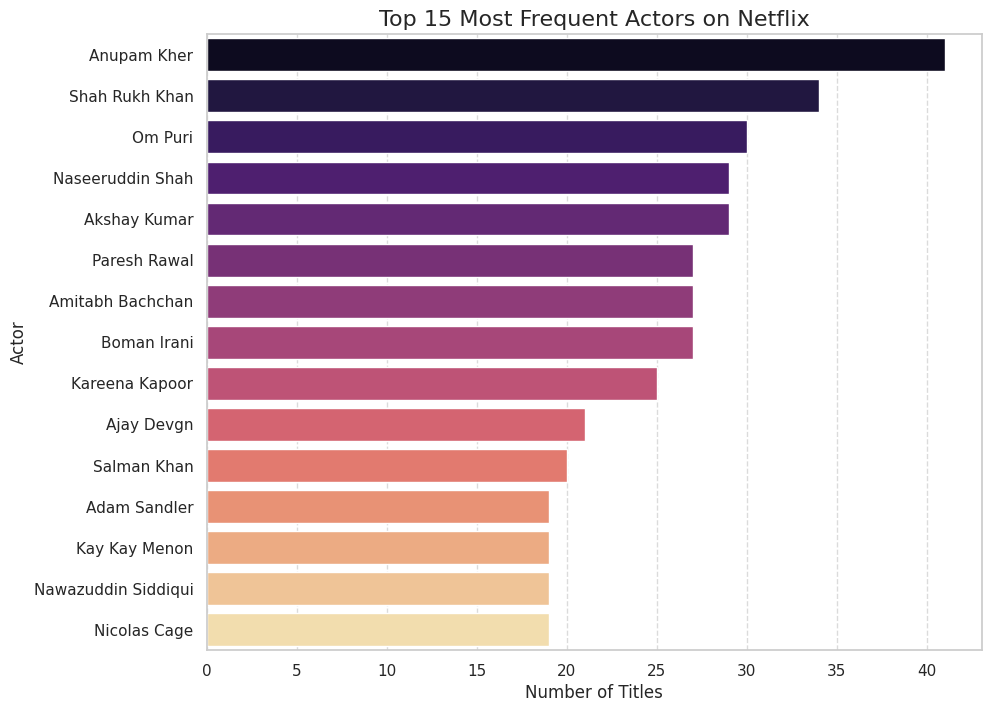

In [86]:
# --- CAST ANALYSIS: Prolific Talent ---
# Cleaning the 'cast' column and counting frequencies
cast_series = df['cast'].str.split(', ').dropna().explode()
top_actors = cast_series[cast_series != 'None'].value_counts().head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_actors.values, y=top_actors.index, palette='magma', hue=top_actors.index, legend=False)
plt.title('Top 15 Most Frequent Actors on Netflix', fontsize=16)
plt.xlabel('Number of Titles', fontsize=12)
plt.ylabel('Actor', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('netflix_cast_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Thematic Word Cloud: Common Narratives

**Key Insight**: The most frequent words in descriptions include "Family," "Life," "Find," "World," and "Love."

**Analysis**: Netflix content focuses heavily on universal human experiences. The prominence of "Family" and "Friend" suggests a strong focus on "four-quadrant" content—shows that appeal to kids, teens, and adults simultaneously.

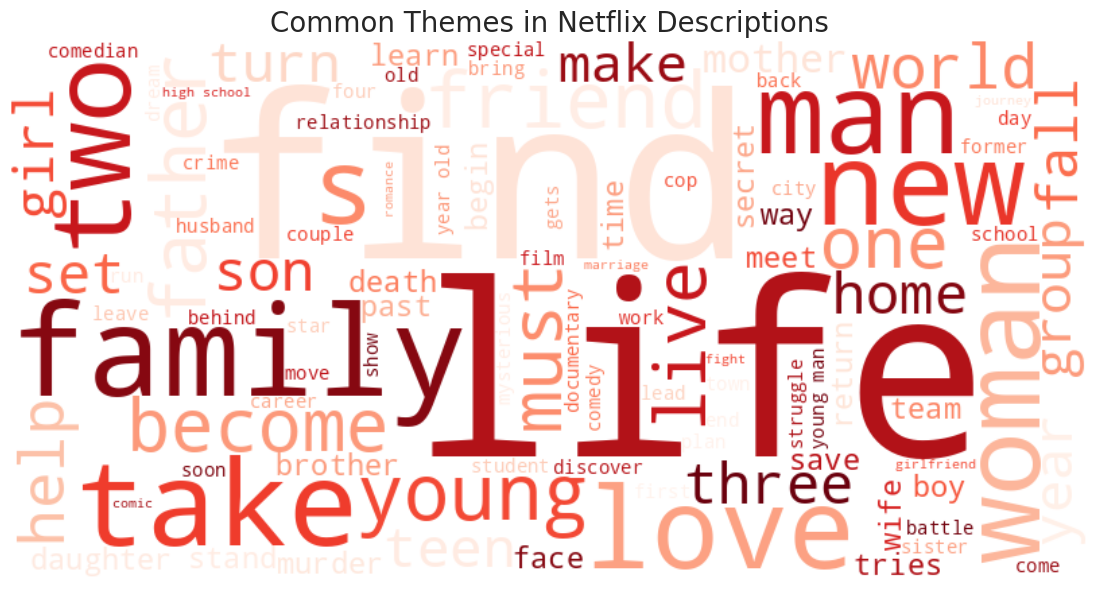

In [87]:
# --- WORD CLOUD: Dominant Themes ---
text = " ".join(desc for desc in df.description.dropna())
wordcloud = WordCloud(width=800, height=400, background_color='White',
                      colormap='Reds', max_words=100).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Themes in Netflix Descriptions", fontsize=20)
plt.show()